## Приложение по доставке продуктов

Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

Результат работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.

В данных имеются логи заказов пользователей:

* ab_users_data – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи
* ab_orders – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ
* ab_products – подробная информация о продуктах, их название и стоимость

## 1. Предобработка и предварительный анализ

* импортируем необходимые для анализа библиотеки:

In [195]:
import numpy as np
import pandas as pd

import scipy.stats as ss
import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt

* подгрузим данные и произведем "первичный" осмотр:

In [196]:
users_data = pd.read_csv('ab_users_data.csv')
orders = pd.read_csv('ab_orders.csv')
products = pd.read_csv('ab_products.csv')

In [197]:
users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [198]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   4337 non-null   int64 
 1   order_id  4337 non-null   int64 
 2   action    4337 non-null   object
 3   time      4337 non-null   object
 4   date      4337 non-null   object
 5   group     4337 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 203.4+ KB


In [199]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [200]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   order_id       4123 non-null   int64 
 1   creation_time  4123 non-null   object
 2   product_ids    4123 non-null   object
dtypes: int64(1), object(2)
memory usage: 96.8+ KB


In [201]:
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [202]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  87 non-null     int64  
 1   name        87 non-null     object 
 2   price       87 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB


In [203]:
users_data.nunique()

user_id     1017
order_id    4123
action         2
time        4312
date          14
group          2
dtype: int64

In [204]:
users_data.query('user_id == 1533')

,user_id,order_id,action,time,date,group
719,1533,2046,create_order,2022-08-26 15:14:30.000000,2022-08-26,1
1595,1533,4140,create_order,2022-08-27 17:05:55.000000,2022-08-27,1
2587,1533,14328,create_order,2022-08-30 19:12:35.000000,2022-08-30,1
2588,1533,14332,create_order,2022-08-30 19:13:06.000000,2022-08-30,1
3248,1533,26880,create_order,2022-09-02 20:39:39.000000,2022-09-02,1
3254,1533,26992,create_order,2022-09-02 20:46:14.000000,2022-09-02,1
3255,1533,26880,cancel_order,2022-09-02 20:46:29.757731,2022-09-02,1
3262,1533,27098,create_order,2022-09-02 21:01:37.000000,2022-09-02,1
3263,1533,27098,cancel_order,2022-09-02 21:07:15.108049,2022-09-02,1
3301,1533,27794,create_order,2022-09-02 23:23:04.000000,2022-09-02,1


* Проверим пересекаются ли наши группы:

In [205]:
len(
    set(users_data.query('group == 0').user_id).intersection(
    set(users_data.query('group == 1').user_id))
   )

0

<b>Получается, пользователи между группами не пересекаются. Отсюда вывод: <u><font color='green'>наши выборки не связаны. </u></font></b>

*Для проведения сравнения результатов эксперимента нужно агрегировать всю нужную информацию по каждому пользователю. По каким параметрам мы будем оценивать результат? Думаю, это, в первую очередь, должны быть количество заказов и количество товаров, далее нужно сравнить суммы выручек. Помимо этого, считаю, необходимым сравнить долю отмененных заказов.*

*Сравнить информацию о времени и датах, считаю, не требуется. Поэтому не будем преобразовывать поля с датами и временем.*

* Сначала агрегируем данные по заказу: сколько товаров и на какую сумму был оформлен заказ. В датафрейме orders коды товаров перечислены через запятую и обрамлены фигурными скобками. Давайте попробуем спарсить нужную нам информацию. Будем использовать list comprehension:




In [206]:
orders['products_list'] = [[int(y) for y in x.split(',')] for x in orders.product_ids.str.strip('{}')]

# получился цикл в цикле, т.к. нам требуется список числового типа для дальнейшего поиска товаров по id в датафрейме products

In [207]:
orders['products_count'] = [len(x) for x in orders.products_list]

# здесь мы определяем кол-во товаров в заказе

In [208]:
orders['order_sum'] = [products[products.product_id.isin(x)].price.sum().round(2) for x in orders.products_list]

# производим поиск товаров и суммируем их цену, тем самым, определяя итоговую сумму заказа

In [209]:
orders

,order_id,creation_time,product_ids,products_list,products_count,order_sum
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}","[75, 22, 53, 84]",4,408.7
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}","[56, 76, 39]",3,250.5
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}","[76, 34, 41, 38]",4,310.2
3,1258,2022-08-26 00:02:56.000000,"{74, 6}","[74, 6]",2,85.0
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}","[20, 45, 67, 26]",4,228.0
...,...,...,...,...,...,...
4118,59422,2022-09-08 23:13:03.000000,"{84, 8, 24}","[84, 8, 24]",3,241.2
4119,59439,2022-09-08 23:18:05.000000,"{9, 25, 75, 30, 6}","[9, 25, 75, 30, 6]",5,518.5
4120,59464,2022-09-08 23:22:27.000000,"{60, 41, 46}","[60, 41, 46]",3,185.9
4121,59487,2022-09-08 23:29:06.000000,"{9, 62, 77}","[9, 62, 77]",3,501.9


* объединим полученные данные по заказам с данные об истории пользовательских действий:

In [210]:
users_data = users_data.merge(orders[['order_id', 'products_count', 'order_sum']], how='inner', on='order_id')
users_data

,user_id,order_id,action,time,date,group,products_count,order_sum
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,4,408.7
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,3,250.5
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,4,310.2
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,2,85.0
4,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0,2,85.0
...,...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1,3,241.2
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1,5,518.5
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0,3,185.9
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0,3,501.9


**Мы хотим сравнить кол-во отмененных заказов, поэтому нужно отдельно выделить созданные и отменные заказы.**

* агрегируем данные по пользователям и группам для созданных заказов:

In [211]:
aggregate = (
               users_data
               .query("action == 'create_order'") 
               .groupby(['user_id', 'group'], as_index=False)
               .agg({'order_id': 'count',
                     'products_count': 'sum',
                     'order_sum': 'sum'})
               .rename(columns={'order_id': 'create_orders_count',
                                'products_count': 'create_products_count',
                                'order_sum': 'create_sum'})
            )
aggregate

,user_id,group,create_orders_count,create_products_count,create_sum
0,964,0,2,8,718.9
1,965,1,9,33,4155.5
2,966,0,1,2,85.0
3,967,1,5,18,1137.4
4,968,0,3,11,1590.7
...,...,...,...,...,...
1012,1976,1,5,16,2001.9
1013,1977,1,4,9,781.2
1014,1978,1,7,21,2766.6
1015,1979,1,6,26,2348.9


* агрегируем данные по пользователям и группам для отмененных заказов:

In [212]:
cancel_orders = (
                users_data
                .query("action == 'cancel_order'")
                .groupby('user_id', as_index=False)
                .agg({'order_id': 'count',
                      'products_count': 'sum',
                      'order_sum': 'sum'})
                .rename(columns={'order_id': 'cancel_orders_count',
                                 'products_count': 'cancel_products_count',
                                 'order_sum': 'cancel_sum'})
                )
cancel_orders

,user_id,cancel_orders_count,cancel_products_count,cancel_sum
0,966,1,2,85.0
1,973,1,3,220.8
2,974,1,4,438.0
3,978,1,3,133.8
4,988,1,3,263.0
...,...,...,...,...
184,1955,1,2,111.5
185,1958,1,2,205.0
186,1961,1,3,428.4
187,1978,1,2,490.3


* для простоты сравнения данных соединим полученные датафреймы в один:

In [213]:
aggregate = aggregate.merge(cancel_orders, how='left', on='user_id')
aggregate

,user_id,group,create_orders_count,create_products_count,create_sum,cancel_orders_count,cancel_products_count,cancel_sum
0,964,0,2,8,718.9,NaN,NaN,NaN
1,965,1,9,33,4155.5,NaN,NaN,NaN
2,966,0,1,2,85.0,1.0,2.0,85.0
3,967,1,5,18,1137.4,NaN,NaN,NaN
4,968,0,3,11,1590.7,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1012,1976,1,5,16,2001.9,NaN,NaN,NaN
1013,1977,1,4,9,781.2,NaN,NaN,NaN
1014,1978,1,7,21,2766.6,1.0,2.0,490.3
1015,1979,1,6,26,2348.9,1.0,5.0,441.8


In [214]:
# для корректных расчетов заполним значения NaN нулями

aggregate.fillna(0, inplace=True) 
aggregate

,user_id,group,create_orders_count,create_products_count,create_sum,cancel_orders_count,cancel_products_count,cancel_sum
0,964,0,2,8,718.9,0.0,0.0,0.0
1,965,1,9,33,4155.5,0.0,0.0,0.0
2,966,0,1,2,85.0,1.0,2.0,85.0
3,967,1,5,18,1137.4,0.0,0.0,0.0
4,968,0,3,11,1590.7,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1012,1976,1,5,16,2001.9,0.0,0.0,0.0
1013,1977,1,4,9,781.2,0.0,0.0,0.0
1014,1978,1,7,21,2766.6,1.0,2.0,490.3
1015,1979,1,6,26,2348.9,1.0,5.0,441.8


*Когда мы агрегировали данные по созданным заказам, мы взяли все заказы, включая те, которые в последующем были отменены.*
* Поэтому выведем отдельно данные только по доставленным заказам, то есть по "неотмененным" заказам:

In [215]:
aggregate['delivered_orders_count'] = aggregate['create_orders_count'] - aggregate['cancel_orders_count']
aggregate['delivered_products_count'] = aggregate['create_products_count'] - aggregate['cancel_products_count']
aggregate['delivered_sum'] = aggregate['create_sum'] - aggregate['cancel_sum']
aggregate

,user_id,group,create_orders_count,create_products_count,create_sum,cancel_orders_count,cancel_products_count,cancel_sum,delivered_orders_count,delivered_products_count,delivered_sum
0,964,0,2,8,718.9,0.0,0.0,0.0,2.0,8.0,718.9
1,965,1,9,33,4155.5,0.0,0.0,0.0,9.0,33.0,4155.5
2,966,0,1,2,85.0,1.0,2.0,85.0,0.0,0.0,0.0
3,967,1,5,18,1137.4,0.0,0.0,0.0,5.0,18.0,1137.4
4,968,0,3,11,1590.7,0.0,0.0,0.0,3.0,11.0,1590.7
...,...,...,...,...,...,...,...,...,...,...,...
1012,1976,1,5,16,2001.9,0.0,0.0,0.0,5.0,16.0,2001.9
1013,1977,1,4,9,781.2,0.0,0.0,0.0,4.0,9.0,781.2
1014,1978,1,7,21,2766.6,1.0,2.0,490.3,6.0,19.0,2276.3
1015,1979,1,6,26,2348.9,1.0,5.0,441.8,5.0,21.0,1907.1


In [216]:
aggregate.group.value_counts()

group
0    515
1    502
Name: count, dtype: int64

<b>Теперь данные готовы к анализу результатов эксперимента по внедрению новой системы рекомендации товаров.

Что мы знаем о наших выборках? Они не связаны, практически равны по размеру, и их размер состовляет порядка 500 записей.



Опеределим метрики, которые будут нас интересовать и сравнение которых позволят нам сделать вывод об эффективности системы рекомендаций:</b>

1. <b><font color='red'>delivered_products_count</font></b> - количество доставленных товаров. Если пользователям стали больше доставляться товары, то можно сделать вывод, что рекомендации действительно помогают пользователям.

2. <b><font color='red'>delivered_sum</font></b> - размер выручки от доставленных товаров. Нам как бизнесу важно понимать, увеличится ли выручка при включении новой системы рекомендаций.

3. <b><font color='red'>delivered_orders_count</font></b> - количество доставленных заказов. Смежное с <i>delivered_products_count</i>, но, думаю, понимание увеличилось ли кол-во заказов, лишним не будет.

4. <b><font color='red'>cross_cancel_delivery_products</font></b> - соотношение количества товаров в отменных и доставленных заказах. Важно понять, порождает ли новая система изменения количества товаров в отменных заказах.

* Начнем анализировать результаты эксперимента и делать выводы с метрики delivered_products_count.

## 2. Сравнение количества доставленных товаров между контрольной и тестовой группами

* Визуализируем значения delivered_products_count между группами:

<Axes: xlabel='group', ylabel='delivered_products_count'>

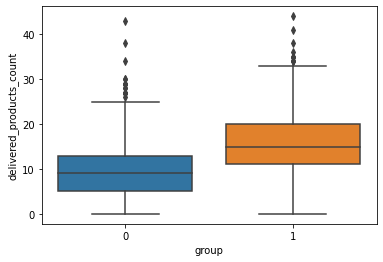

In [217]:
sns.boxplot(data=aggregate, x='group', y = 'delivered_products_count')

In [218]:
aggregate.query('group == 0').delivered_products_count.describe()

count    515.000000
mean       9.908738
std        6.480547
min        0.000000
25%        5.000000
50%        9.000000
75%       13.000000
max       43.000000
Name: delivered_products_count, dtype: float64

In [219]:
aggregate.query('group == 1').delivered_products_count.describe()

count    502.000000
mean      15.896414
std        7.643845
min        0.000000
25%       11.000000
50%       15.000000
75%       20.000000
max       44.000000
Name: delivered_products_count, dtype: float64

Исходя из полученных данных видно:
* стандартное отклонение в тестовой группе немного больше, чем в контрольной;
* среднее значение delivered_products_count у тестовой группы больше, чем у контрольной почти в 1.5 раза.

Давайте попробуем понять насколько различия в **delivered_products_count** статистически значимы.

* Для начала проверим наши распределения на нормальность:

Text(0.5, 1.0, 'experiment (group = 1)')

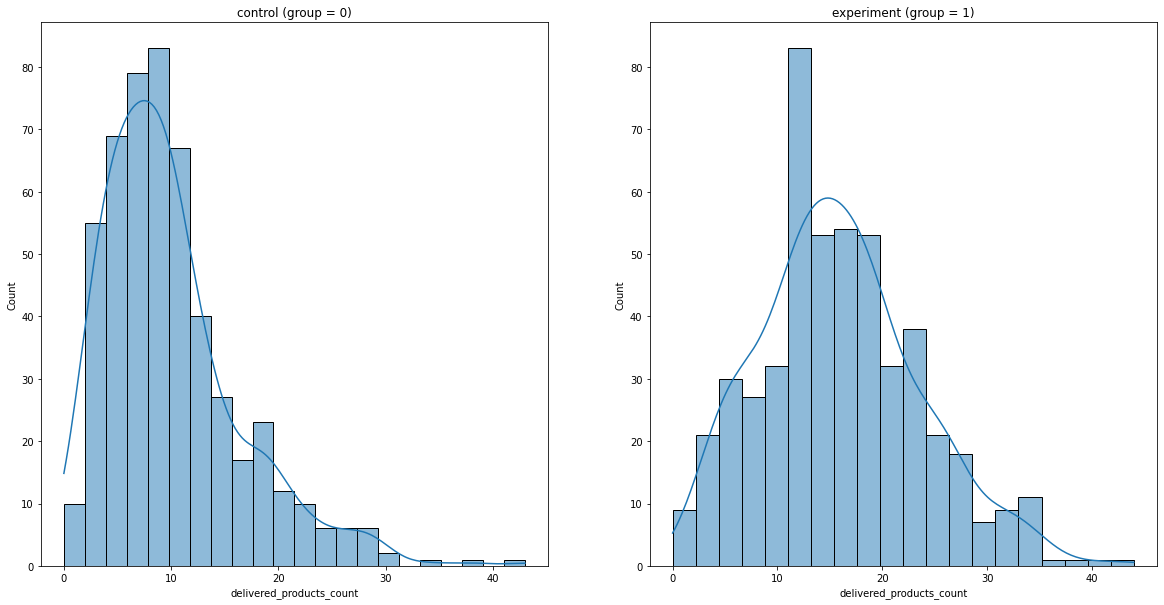

In [220]:
fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(20)
fig.set_figheight(10)

sns.histplot(data=aggregate.query('group == 0'), x='delivered_products_count', kde=True, ax=axs[0])
axs[0].set_title('control (group = 0)')
sns.histplot(data=aggregate.query('group == 1'), x='delivered_products_count', kde=True, ax=axs[1])
axs[1].set_title('experiment (group = 1)')

In [221]:
pg.normality(data=aggregate, dv='delivered_products_count', group='group')

,W,pval,normal
group,,,
0,0.901170,9.629125e-18,False
1,0.981298,4.702332e-06,False


<i>Тест на нормальность показал, что наши выборки не имеют нормального распределения.

Мы хотим понять, есть ли статистически значимые различия между двумя группами. Будем сравнивать средние значения количества доставленных товаров.  

Нормальность данных критична только для очень маленьких выборок (примерный ориентир – меньше 30). У нас выборки по 500 записей в каждой, поэтому т-тест будет работать корректно. Тест должен быть параметрическим, т.к. все параметры выборки нам известны.

Плюс мы знаем, что стандартные отклонения наших выборок не равны. Поэтому для сравнения средних значений между двумя группами будем использовать <u>т-критерий Уэлча</u> для наших несвязанных выборок, где:</i>
* <b><font color='red'> $H_0$ (нулевая гипотеза) говорит, о том что средние значения не отличаются;</font></b>

* <b><font color='green'> $H_1$ (альтернативная гипотеза) говорит, о том что средние значения в выборках отличаются.</font></b>

Если рассчитанное p-value будет меньше 0.05, можно будет отвергнуть нулевую гипотезу.

* Произведем расчеты т-теста разными библиотеками: 

In [222]:
pg.ttest(aggregate.query('group == 0').delivered_products_count, 
         aggregate.query('group == 1').delivered_products_count,
         correction=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-13.458352,980.047296,two-sided,5.209942e-38,"[-6.86, -5.11]",0.845875,4.934e+34,1.0


In [223]:
ss.ttest_ind(aggregate.query('group == 0').delivered_products_count, 
             aggregate.query('group == 1').delivered_products_count,
             equal_var=False)

Ttest_indResult(statistic=-13.458351575919488, pvalue=5.2099416581148e-38)

**Мы получили в качестве p-value очень маленькое число со степенью "-(минус) 38". Это говорит нам, что мы можем отвергнуть нулевую гипотезу и сделать вывод, что <font color='green'>средние между двумя группами статистически различаются.</font>** 

**Отрицательное значение переменной т-статистики говорит нам о том, что значения среднего кол-ва доставленных товаров в тестовой группе выше, чем в контрольной. То есть мы статистически подтвердили полученные выше данные.**



## 3. Сравнение средней суммы покупок между 2 группами

* Визуализируем значения delivered_sum между группами 

<Axes: xlabel='group', ylabel='delivered_sum'>

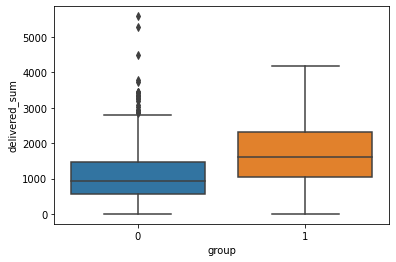

In [224]:
sns.boxplot(data=aggregate, x='group', y = 'delivered_sum')

In [225]:
aggregate.query('group == 0').delivered_sum.describe()

count     515.000000
mean     1112.096311
std       799.289632
min         0.000000
25%       555.750000
50%       927.900000
75%      1456.200000
max      5589.800000
Name: delivered_sum, dtype: float64

In [226]:
aggregate.query('group == 1').delivered_sum.describe()

count     502.000000
mean     1715.278088
std       904.426671
min         0.000000
25%      1039.975000
50%      1611.550000
75%      2314.800000
max      4189.500000
Name: delivered_sum, dtype: float64

Исходя из полученных данных видно:
* стандартное отклонение в тестовой группе больше, чем в контрольной;
* максимальная сумма покупки больше у контрольной группы;
* отсутствие выбросов данных в тестовой группе;
* среднее значение delivered_sum у тестовой группы больше, чем у контрольной почти в 1.5 раза.

Давайте попробуем понять насколько различия в **delivered_sum** статистически значимы.

* Для начала проверим наши распределения на нормальность:

Text(0.5, 1.0, 'experiment (group = 1)')

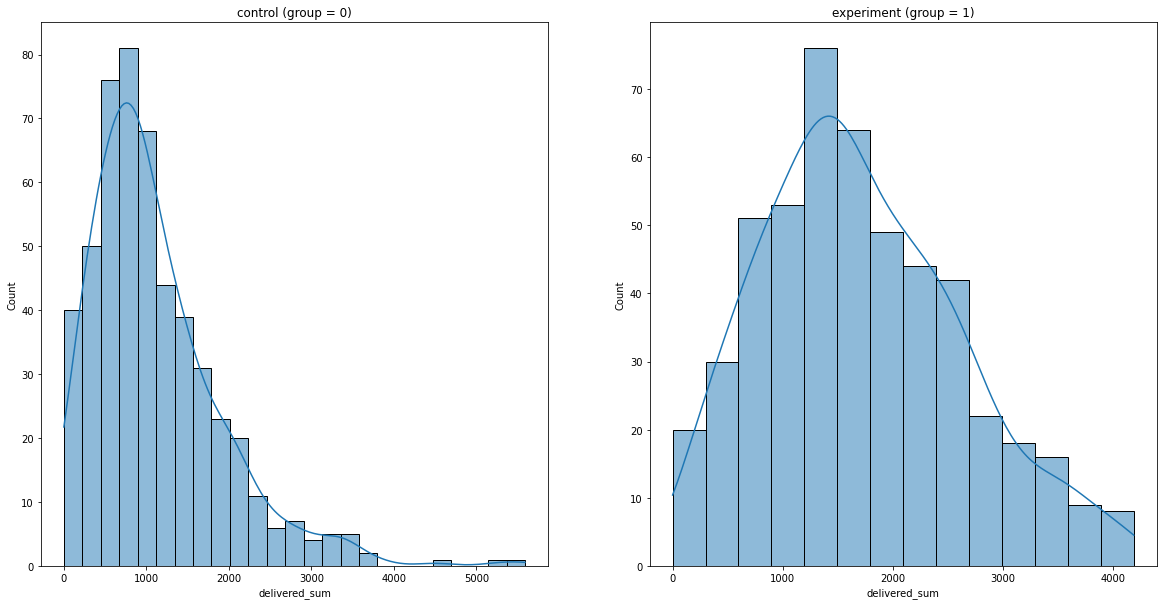

In [227]:
fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(20)
fig.set_figheight(10)

sns.histplot(data=aggregate.query('group == 0'), x='delivered_sum', kde=True, ax=axs[0])
axs[0].set_title('control (group = 0)')
sns.histplot(data=aggregate.query('group == 1'), x='delivered_sum', kde=True, ax=axs[1])
axs[1].set_title('experiment (group = 1)')

In [228]:
pg.normality(data=aggregate, dv='delivered_sum', group='group')

,W,pval,normal
group,,,
0,0.887996,6.878394e-19,False
1,0.976329,2.912343e-07,False


<i>Тест на нормальность показал, что наши выборки не имеют нормального распределения.

Мы хотим понять, есть ли статистически значимые различия между двумя группами. Будем сравнивать средние значения суммы покупок у пользователей.  

Нормальность данных критична только для очень маленьких выборок (примерный ориентир – меньше 30). У нас выборки по 500 записей в каждой, поэтому т-тест будет работать корректно. Тест должен быть параметрическим, т.к. все параметры выборки нам известны.

Плюс мы знаем, что стандартные отклонения наших выборок не равны. Поэтому для сравнения средних значений между двумя группами будем использовать <u>т-критерий Уэлча</u> для наших несвязанных выборок, где:</i>
* <b><font color='red'> $H_0$ (нулевая гипотеза) говорит, о том что средние значения не отличаются;</font></b>

* <b><font color='green'> $H_1$ (альтернативная гипотеза) говорит, о том что средние значения в выборках отличаются.</font></b>

Если рассчитанное p-value будет меньше 0.05, можно будет отвергнуть нулевую гипотезу.

* Произведем расчеты т-теста разными библиотеками: 

In [229]:
pg.ttest(aggregate.query('group == 0').delivered_sum, 
         aggregate.query('group == 1').delivered_sum,
         correction=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-11.259252,993.145386,two-sided,9.236911e-28,"[-708.31, -498.05]",0.70729,3.284e+24,1.0


In [230]:
ss.ttest_ind(aggregate.query('group == 0').delivered_sum, 
             aggregate.query('group == 1').delivered_sum,
             equal_var=False)

Ttest_indResult(statistic=-11.259252181082747, pvalue=9.236910748284077e-28)

**Мы получили в качестве p-value очень маленькое число со степенью "-(минус) 28". Это говорит нам, что мы можем отвергнуть нулевую гипотезу и сделать вывод, что <font color='green'>средние между двумя группами статистически различаются.</font>** 

**Отрицательное значение переменной т-статистики говорит нам о том, что значения средней суммы покупок в тестовой группе выше, чем в контрольной. То есть мы статистически подтвердили полученные выше данные.**



## 4. Сравнение количества доставленных заказов между контрольной и тестовой группами

* Визуализируем значения delivered_orders_count между группами:

<Axes: xlabel='group', ylabel='delivered_orders_count'>

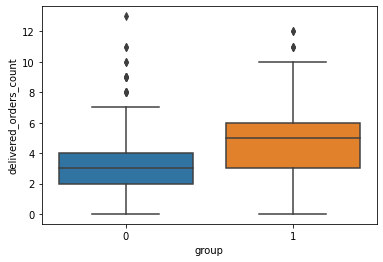

In [231]:
sns.boxplot(data=aggregate, x='group', y = 'delivered_orders_count')

In [232]:
aggregate.query('group == 0').delivered_orders_count.describe()

count    515.000000
mean       2.965049
std        1.894786
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       13.000000
Name: delivered_orders_count, dtype: float64

In [233]:
aggregate.query('group == 1').delivered_orders_count.describe()

count    502.000000
mean       4.745020
std        2.146976
min        0.000000
25%        3.000000
50%        5.000000
75%        6.000000
max       12.000000
Name: delivered_orders_count, dtype: float64

Исходя из полученных данных видно:
* стандартное отклонение в тестовой группе немного больше, чем в контрольной;
* максимальное количество заказов больше у контрольной группы;
* отсутствие выбросов данных в тестовой группе;
* среднее значение delivered_orders_count у тестовой группы больше, чем у контрольной почти в 1.5 раза.

Давайте попробуем понять насколько различия в **delivered_orders_count** статистически значимы.

* Для начала проверим наши распределения на нормальность:

Text(0.5, 1.0, 'experiment (group = 1)')

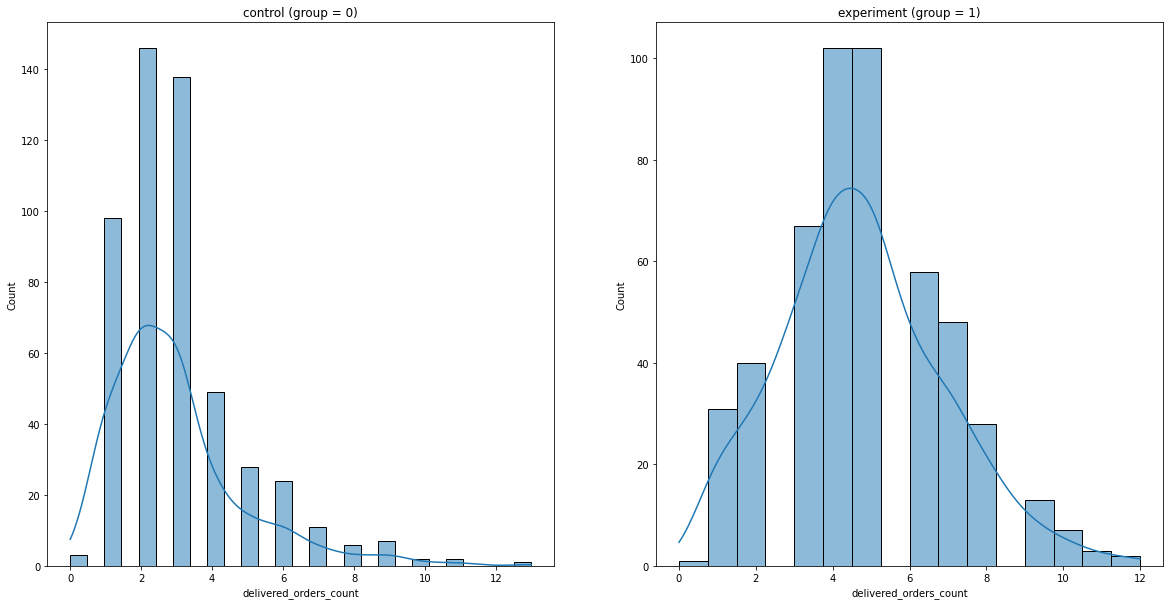

In [234]:
fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(20)
fig.set_figheight(10)

sns.histplot(data=aggregate.query('group == 0'), x='delivered_orders_count', kde=True, ax=axs[0])
axs[0].set_title('control (group = 0)')
sns.histplot(data=aggregate.query('group == 1'), x='delivered_orders_count', kde=True, ax=axs[1])
axs[1].set_title('experiment (group = 1)')

In [235]:
pg.normality(data=aggregate, dv='delivered_orders_count', group='group')

,W,pval,normal
group,,,
0,0.836956,1.460894e-22,False
1,0.965844,2.068508e-09,False


<i>Тест на нормальность показал, что наши выборки не имеют нормального распределения.

Мы хотим понять, есть ли статистически значимые различия между двумя группами. Будем сравнивать средние значения количества доставленных заказов у пользователей.  

Нормальность данных критична только для очень маленьких выборок (примерный ориентир – меньше 30). У нас выборки по 500 записей в каждой, поэтому т-тест будет работать корректно. Тест должен быть параметрическим, т.к. все параметры выборки нам известны.

Плюс мы знаем, что стандартные отклонения наших выборок не равны. Поэтому для сравнения средних значений между двумя группами будем использовать <u>т-критерий Уэлча</u> для наших несвязанных выборок, где:</i>
* <b><font color='red'> $H_0$ (нулевая гипотеза) говорит, о том что средние значения не отличаются;</font></b>

* <b><font color='green'> $H_1$ (альтернативная гипотеза) говорит, о том что средние значения в выборках отличаются.</font></b>

Если рассчитанное p-value будет меньше 0.05, можно будет отвергнуть нулевую гипотезу.

* Произведем расчеты т-теста разными библиотеками: 

In [236]:
pg.ttest(aggregate.query('group == 0').delivered_orders_count, 
         aggregate.query('group == 1').delivered_orders_count,
         correction=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-14.004857,992.754283,two-sided,8.436865e-41,"[-2.03, -1.53]",0.879781,2.653e+37,1.0


In [237]:
ss.ttest_ind(aggregate.query('group == 0').delivered_orders_count, 
             aggregate.query('group == 1').delivered_orders_count,
             equal_var=False)

Ttest_indResult(statistic=-14.004857145357283, pvalue=8.436864886644697e-41)

**Мы получили в качестве p-value очень маленькое число со степенью "-(минус) 41". Это говорит нам, что мы можем отвергнуть нулевую гипотезу и сделать вывод, что <font color='green'>средние между двумя группами статистически различаются.</font>** 

**Отрицательное значение переменной т-статистики говорит нам о том, что значения среднего кол-ва доставленных заказов в тестовой группе выше, чем в контрольной. То есть мы статистически подтвердили полученные выше данные.**



## 5. Сравнение количества товаров в отмененных заказах между контрольной и тестовой группами


*Мы хотим определить зависимость от группы пользователей распределения двух категориальных переменных: "доставленные товары" и "отмененные товары". Для этого воспользуемся <u>критерием Хи-квадрата.</u> Будем использовать таблицу сопряженности. Поправку Йетса использовать не будем, т.к. у нас больше 10 наблюдений.*

* <b><font color='red'> $H_0$ (нулевая гипотеза) говорит, о том распределение не зависит от группы пользователей;</font></b>

* <b><font color='green'> $H_1$ (альтернативная гипотеза) говорит, о распределение зависит от группы.</font></b>

Если рассчитанное p-value будет меньше 0.05, можно будет отвергнуть нулевую гипотезу.

* Сначала агрегируем данные и определим кол-во товаров в отмененных и доставленных товарах внутри наши групп:

In [238]:
aggregate.head()

,user_id,group,create_orders_count,create_products_count,create_sum,cancel_orders_count,cancel_products_count,cancel_sum,delivered_orders_count,delivered_products_count,delivered_sum
0,964,0,2,8,718.9,0.0,0.0,0.0,2.0,8.0,718.9
1,965,1,9,33,4155.5,0.0,0.0,0.0,9.0,33.0,4155.5
2,966,0,1,2,85.0,1.0,2.0,85.0,0.0,0.0,0.0
3,967,1,5,18,1137.4,0.0,0.0,0.0,5.0,18.0,1137.4
4,968,0,3,11,1590.7,0.0,0.0,0.0,3.0,11.0,1590.7


In [239]:
cross_cancel_delivery_products = (
                        aggregate.groupby('group', as_index=False)
                                 .agg({'cancel_products_count': 'sum', 
                                       'delivered_products_count': 'sum'})
                                 .rename(columns={'cancel_products_count': 'cancel',
                                                  'delivered_products_count': 'delivered'})
                                 .pivot_table(columns=['group'])
                                 .add_suffix('_group')
)
cross_cancel_delivery

group,0_group,1_group
cancel,287.0,456.0
delivered,5103.0,7980.0


*Мы получили так называемую таблицу сопряжённости*
* Определим p-value критерия Хи-квадрата с помощью библиотеки **scipy:**

In [240]:
res = ss.chi2_contingency(cross_cancel_delivery_products)
res.pvalue

0.8676528160493342

**Мы получили в качестве p-value значение намного больше 0.05. Это говорит нам, что мы не можем отвергнуть нулевую гипотезу. Поэтому можно сделать вывод, что <font color='green'>распределение кол-ва товаров в отмененных заказах между двумя группами статистически не различаются.</font>** 



# Аналитическое заключение проведенного анализа данных

<i>Сравнив контрольную и экспериментальную (тестовую) группы по 4 метрикам: кол-во доставленных заказов и товаров, сумма выручки и соотношение отменных и доставленных товаров можно сделать следующий вывод.</i>

* Эксперимент показал, что количество доставляемых заказов и, главное, количество доставляемых товаров с новой системой рекомендаций статистически значимо увеличилось. Более того, у нас увеличилась средняя сумма выручки с пользователя. Соотношение количества товаров в отмененных заказах не изменилось. Поэтому новая система рекомендаций действительно принесла пользу нашим пользователям и нам, как бизнесу. 

<b>Резюме: <p><font color='green'>> Предлагаем включить новую систему рекомендаций товаров для всех пользователей нашего сервиса.</font></b></p>